In [1]:
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
import os
import time
from IPython import display

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


os.listdir('../input')

Using TensorFlow backend.


['data_records_27638.txt',
 'faulty_images.txt',
 'flavours.csv',
 'metadata27368.csv',
 'images27638']

In [2]:
# read metadata

df_meta = pd.read_csv('../input/metadata27368.csv')
#df_meta.head()

In [3]:
# import flavours

df_flav = pd.read_csv('../input/flavours.csv')
#df_flav.head()
df_Sweet = df_flav['Sweet']
df_Sweet.head()

0       NaN
1    0.3333
2    0.3333
3    0.1667
4    0.1667
Name: Sweet, dtype: float64

In [4]:
# import faulty images indexes

file = open("../input/faulty_images.txt", "r")
faul_id = []
for val in file.read().split():
    faul_id.append(int(val)-1)
file.close()
print(len(faul_id),"faulty images")

262 faulty images


In [5]:
# get the unlabeled images indexes

# search for nan values in flavours df
nan_bool = df_flav.isnull().any(axis=1)
nan_id = np.where(nan_bool == True)[0]
print(len(nan_id),'unlabeled images')

4886 unlabeled images


In [6]:
# remove faulty images from unlabeles

f_nan_id = []
for i in faul_id:
    t = np.where(nan_id == i)[0]
    if len(t) != 0:
        f_nan_id.append(t)
nan_id = np.delete(nan_id, f_nan_id)

print(len(nan_id),'true unlabeled images')

4827 true unlabeled images


In [7]:
# Good images !

good_id = np.arange(27638)
good_id = np.delete(good_id, np.union1d(faul_id, nan_id))

print(len(good_id))



22549


In [8]:
# Train and validation split 
train_id, val_id, _, _ = train_test_split(good_id, good_id, test_size=0.2)

print('Train', len(train_id))
print('Val',len(val_id))

Train 18039
Val 4510


In [9]:
# creat a useful dictionary structures

partition = {}
partition['train'] = train_id
partition['validation'] = val_id
partition['faulty'] = faul_id
partition['no_label'] = nan_id

labels = {}
name = {}
image = {}
for i in range(27638):
    
    labels[str(i)] = df_Sweet.iloc[[i]].values[0] # every label is a panda df rows
    
    name[str(i)] = df_meta['name'][i]
    
    im = str(i+1)
    while len(im) < 5 :
        im = '0' + im
    im ='img' + im + '.jpg'
    image[str(i)] = im

In [10]:
# test dictionaries

print(labels['1'])

print(name['1'])

print(image['1'])

0.3333
Filipino BBQ Pork Skewers
img00002.jpg


In [11]:
def encode_label(labels, ID):
    
    out = np.empty((len(ID), 1))
    
    for i, id in enumerate(ID):
        t = labels[str(id)]
        if t < 0.1:
            t = 0
        elif 0.1 < t < 0.3:
            t = 1
        elif 0.3 < t < 0.4:
            t = 2
        elif 0.4 < t < 0.6:
            t = 3
        elif 0.6 < t < 0.8:
            t = 4
        elif 0.8 < t < 0.9:
            t = 5
        else:
            t = 6
            
        out[i] = t
        
    return out

In [45]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128, 128), n_channels=3,
                 n_classes=6, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            im = Image.open("../input/images27638/images27638/"+image[str(ID)])
            im = im.resize((128, 128), Image.ANTIALIAS)
            im.load()
            X[i,] = np.asarray(im, dtype=np.uint8 )/255
            y[i] = np.asarray(im, dtype=np.uint8 )/255

        return X, y

In [46]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
model = Sequential()

#Encoder

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,128,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))

#Decoder

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
__________

In [48]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):


    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [49]:
# Define batch size.
batch_size = 64
n_epoch = 25
val_size = len(val_id)


# Parameters
params = {'dim': (128, 128),
          'batch_size': batch_size,
          'n_classes': 7,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)


In [50]:
file_dir = '../working//Model'
network_filepath = os.path.join(file_dir, 'best_model.h5')
os.mkdir(file_dir)

FileExistsError: [Errno 17] File exists: '../working//Model'

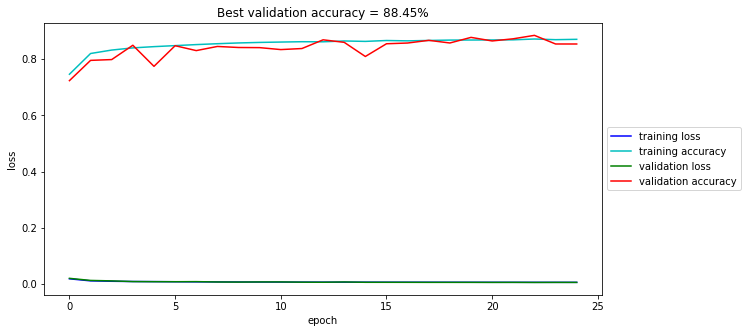

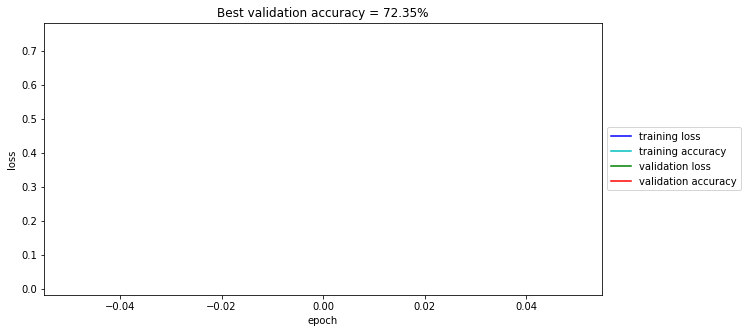

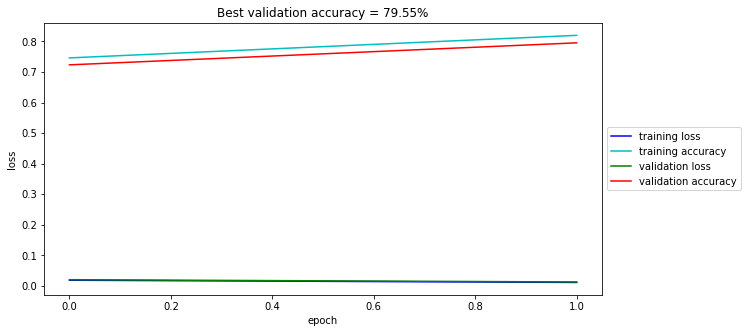

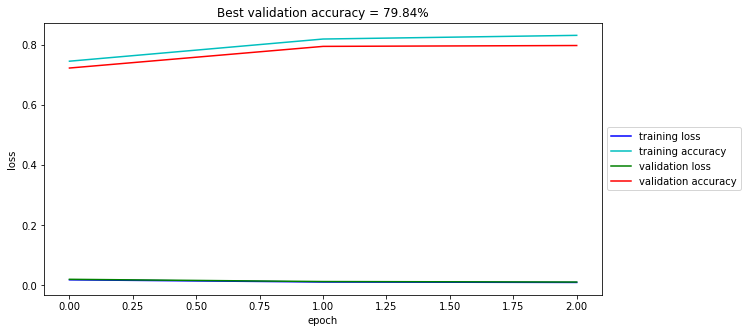

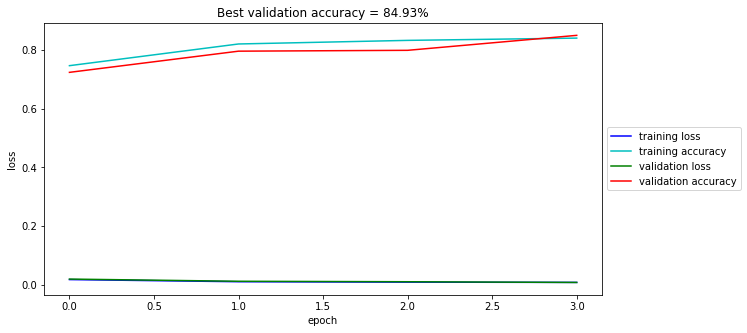

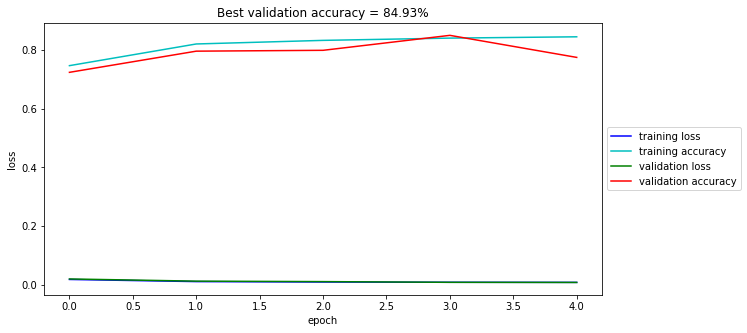

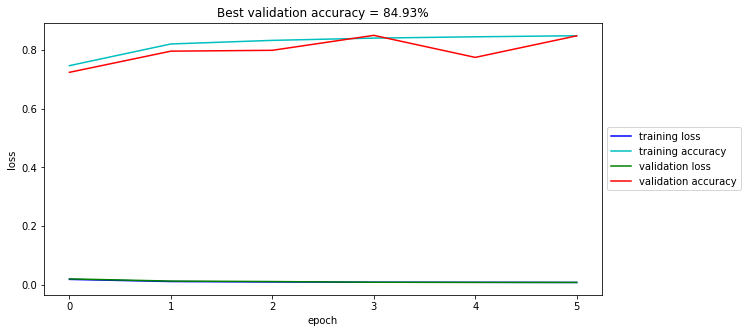

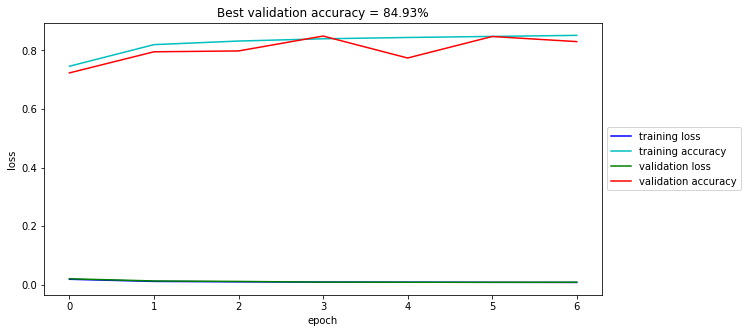

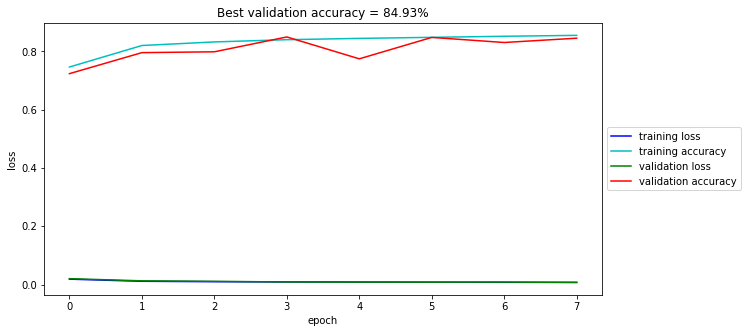

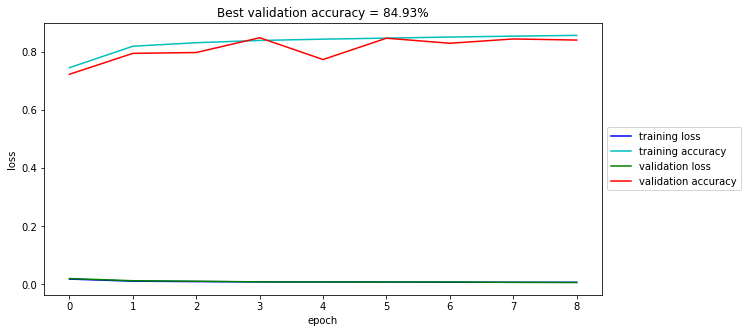

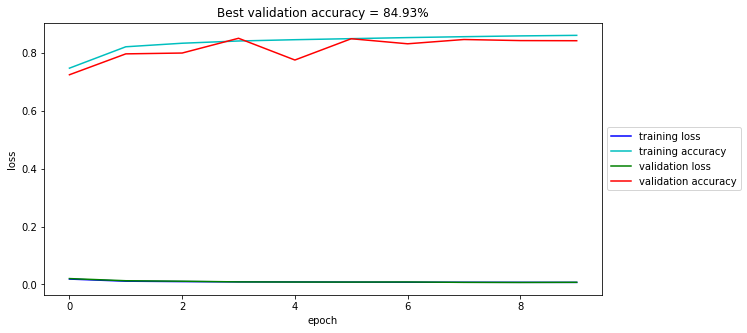

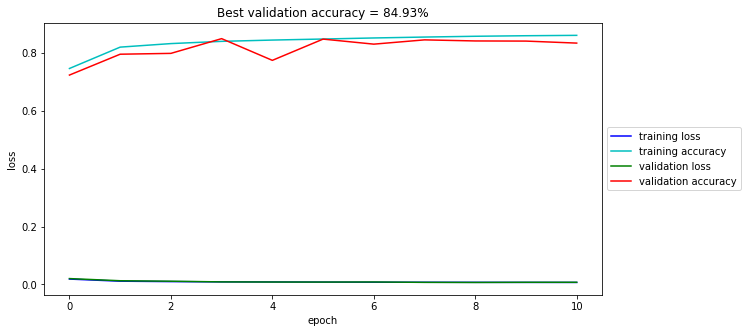

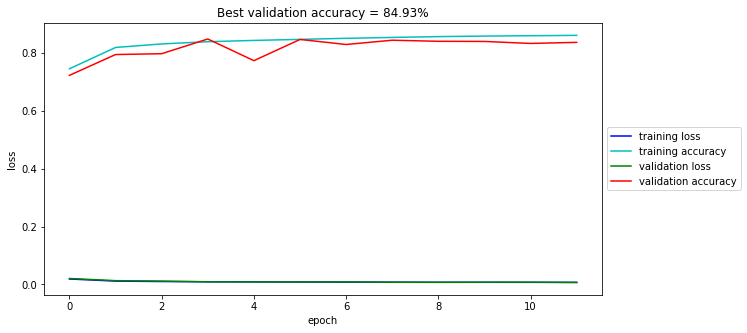

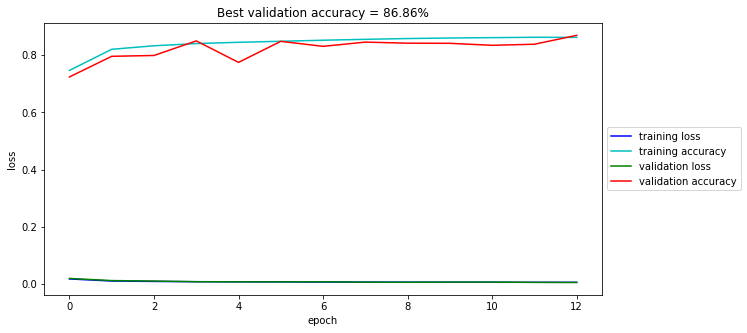

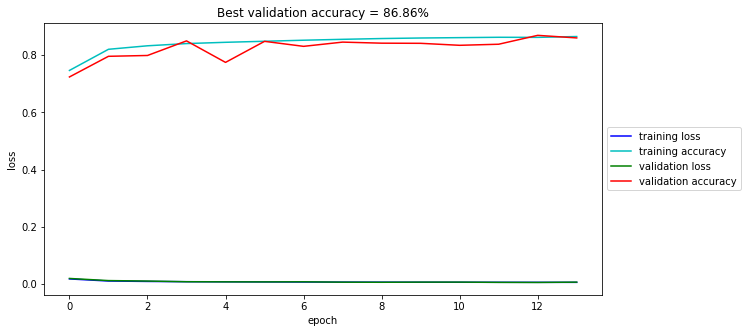

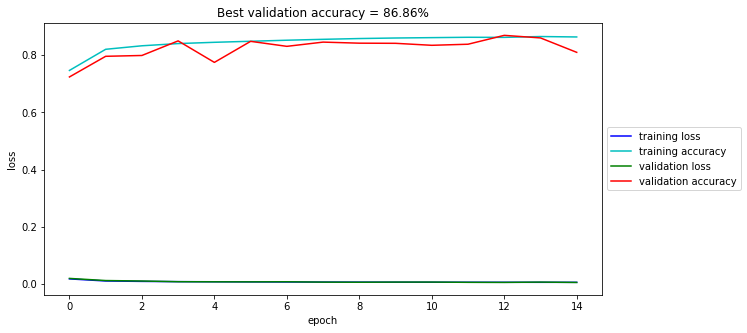

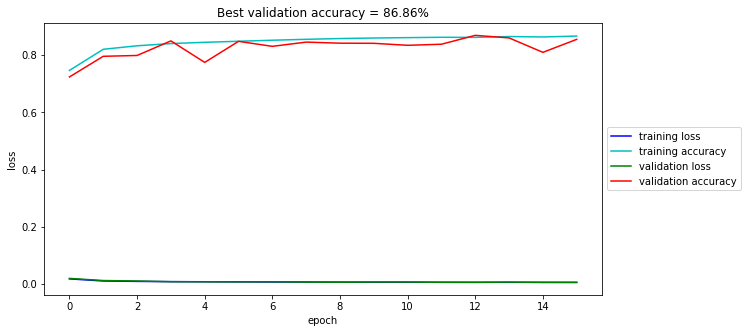

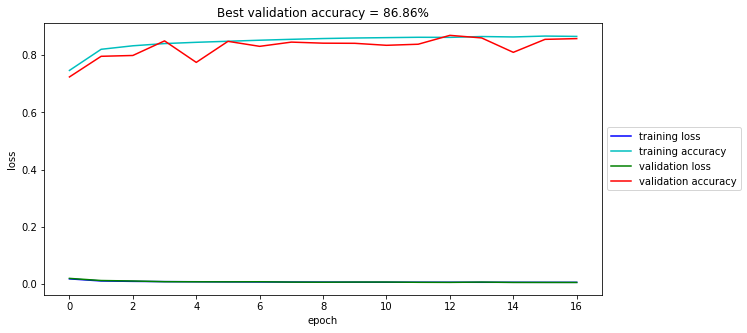

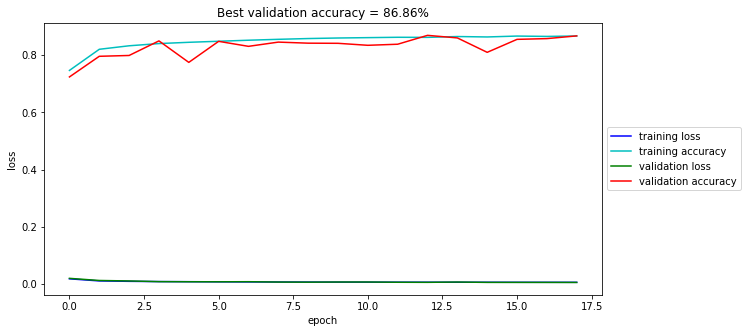

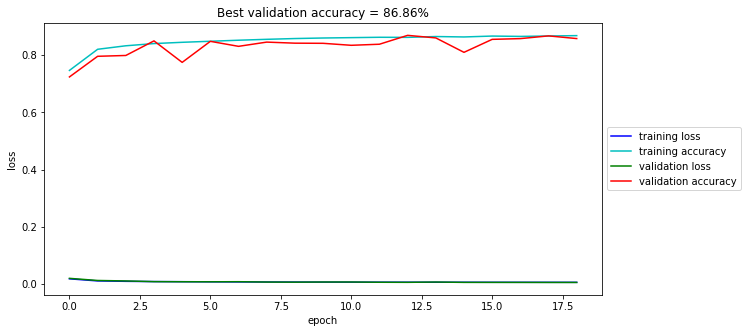

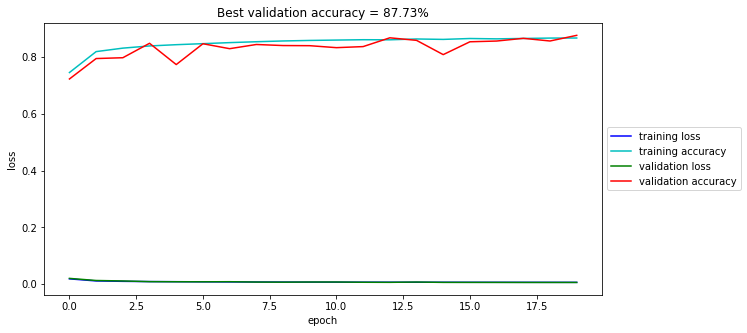

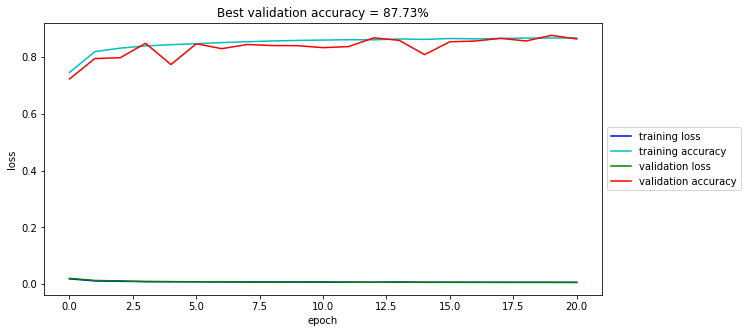

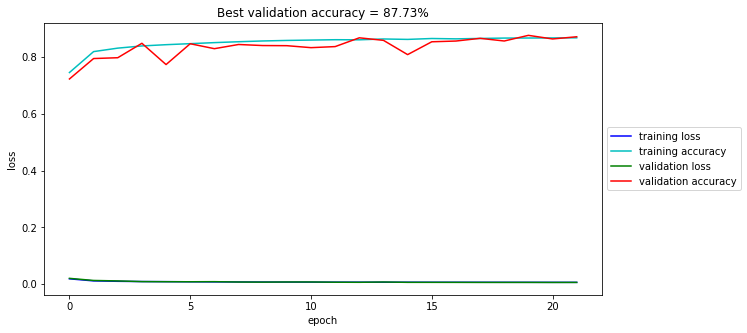

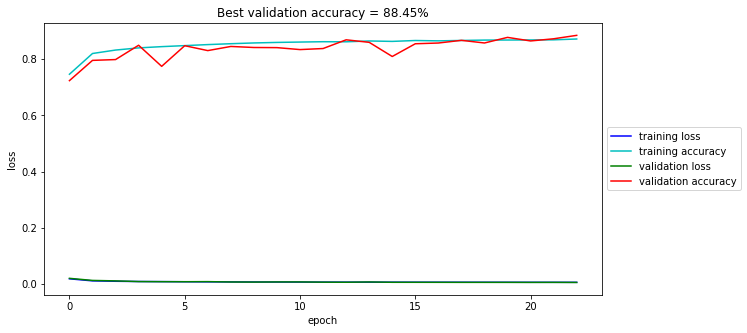

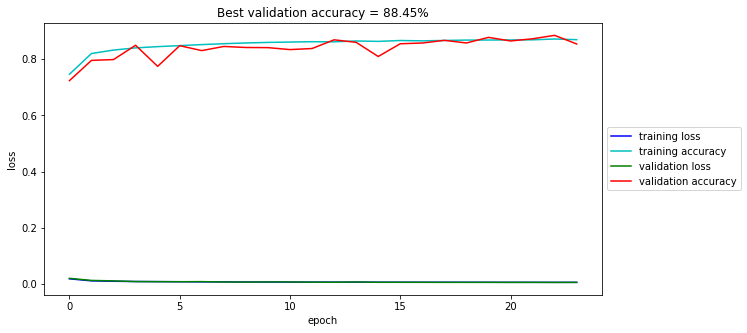

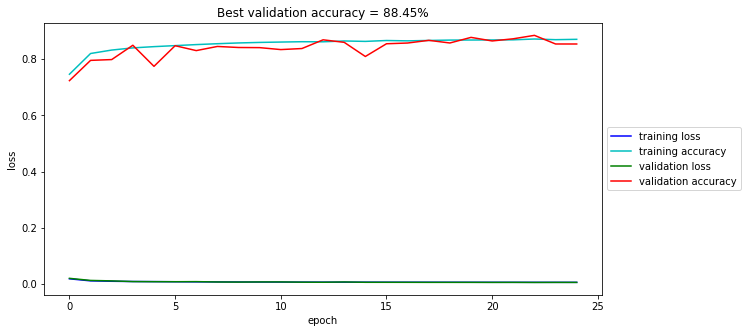

In [51]:
train_network(model, training_generator, validation_generator, n_epoch, network_filepath)

In [52]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

In [ ]:
pred = model.predict(X_test)

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, ..., 0])
    curr_lbl = y_test[i]
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0])  
plt.show()

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)


Gluten Free Grilled Orange Chicken
0.6667


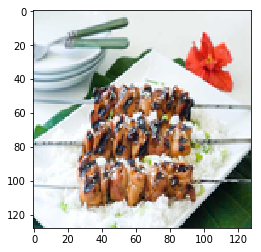

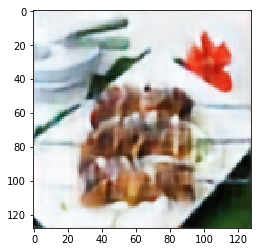

In [65]:
test = str(val_id[122])

print(name[test])
print(labels[test])
im = Image.open("../input/images27638/images27638/"+image[test])
im = im.resize((128, 128), Image.ANTIALIAS)
im.load()
im = np.asarray(im, dtype=np.uint8)/255
plt.imshow(im)
plt.show()
im = np.expand_dims(im, axis=0)


pred = best_network.predict(im)
#print('Prediction',pred[0])
plt.imshow(pred[0])

In [ ]:
pred_nan = np.empty((len(nan_id), 7))
pred_name = []
for i, id in enumerate(nan_id):
    test = str(id)
    pred_name.append(name[test])
    im = Image.open("../input/images27638/images27638/"+image[test])
    im = im.resize((224, 224), Image.ANTIALIAS)
    im.load()
    im = np.asarray(im, dtype=np.uint8 )
    im = np.expand_dims(im, axis=0)
    pred = best_network.predict(im)
    pred_nan[i] = pred

In [ ]:
print(pred_nan)

In [ ]:
print(pred_nan[0:50, 6])

In [ ]:
encoded_labels = encode_label(labels, good_id)

plt.hist(encoded_labels)

In [ ]:
###very unbalance classes